# 多項式回帰をベイズでやってみる

In [2]:
# ライブラリ
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# 超パラメータ
lambda_ = 10 # 誤差の分散パラメータ 分散の逆数。λが大⇒観測の誤差が小さい
dim = 4 # 多項式の次元4なら3次関数で推定するということ

## ベイズ回帰の枠組み
+ モデルは、$y = w^t x + \epsilon$で確率モデルで書くと、$N(w^tx,\epsilon)$ (xは何か非線形変換されていることを想定。今回は多項式変換)
+ 事前分布$p(w)$は正規分布で与える。事前知識があればそれに従えばいいが、普通は平均:$m$=0ベクトルで共分散行列:$\Lambda$は単位行列を与える。
+ 事後分布p(w|x)は正規分布になり（共分散既知、平均未知のため）平均、共分散は以下で与えられる。
+ $\Lambda' =  \lambda\sum_n (x_n x_n^t) + \Lambda$
+ $m ' =  \Lambda'^-1 (\lambda \sum_n (y_n x_n) + \Lambda m)$
+ 予測分布p(y_*|x_*)は同様に正規分布となり、平均・共分散は以下で与えられる。
+ $m" = m'^t x_*$ 
+ $\lambda"^{-1} = \lambda^{-1}  + x_*^t\Lambda'x_*$

In [60]:
# データ生成
train_x = np.random.uniform(0, 2*np.pi, 10)
epsilon = np.random.normal(0, np.sqrt((1/lambda_)), 10)
train_y = np.sin(train_x) + epsilon
def bayesian_polynomial_regression(size, dim):
    # 事前分布
    m = np.zeros(dim)
    Lambda =np.eye(dim)
    w = np.random.multivariate_normal(m,Lambda, 1) # 事前分布は平均0ベクトル、共分散分散行列が単位行列の正規分布で与える。
    # 学習用のinput    
    x_stack = np.vstack([np.ones(size)] + [np.power(train_x, i) for i in range(1, dim)]).T
    
    
    # 事後分布のパラメータ（平均、共分散行列）
    Lambda_prime = np.zeros((dim, dim))
    mean_prime = np.zeros((dim, 1))
    for _x, _y in zip(x_stack, train_y):
        _x = _x.reshape((dim,1))
        Lambda_prime += np.dot(_x, _x.T)
        mean_prime += _y*_x
    Lambda_prime = Lambda_prime*lambda_ +Lambda
    Lambda_prime_inv = np.linalg.inv(Lambda_prime) # 逆行列
    mean_prime =(mean_prime*lambda_).flatten() + np.dot(Lambda, m)
    mean_prime = np.dot(Lambda_prime_inv, mean_prime)
    # 予測分布
    x_new = np.arange(0, 6.28, 0.01) #可視化用
    x_new_stack = np.stack([np.ones(len(x_new))] + [np.power(x_new, i) for i in range(1, dim)]).T
    m_star = np.dot(x_new_stack, mean_prime)
    lambda_star_inv = 1/lambda_ + np.array([_x.dot(Lambda_prime_inv).dot(_x) for _x in x_new_stack])
    return m_star, lambda_star_inv

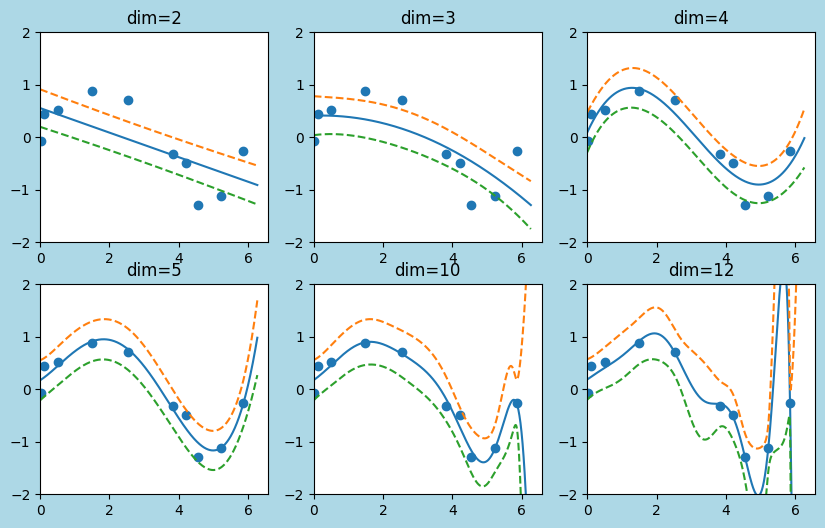

In [63]:
# 色々な次元でやってみる
fig = plt.figure(figsize = (10,6), facecolor='lightblue')
ax_list = [fig.add_subplot(2, 3, i+1) for i in range(6)]
x = np.arange(0, 6.28, 0.01)
for i, ax in zip([2,3,4,5,10,12], ax_list):
    m_star, lambda_star_inv= bayesian_polynomial_regression(10, i)
    ax.plot(x, m_star) # 予測の期待値
    ax.plot(x, m_star + np.sqrt(lambda_star_inv), linestyle='--') # 予測の期待値 + 標準偏差
    ax.plot(x, m_star - np.sqrt(lambda_star_inv), linestyle='--') # 予測の期待値 - 標準偏差
    ax.scatter(train_x, train_y)
    ax.set_xlim(0, 2*np.pi+0.3)
    ax.set_ylim(-2, 2)
    ax.set_title(f'dim={i}')
    